In [1]:
import h5py
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
import pandas as pd
import get_ecg as ge
import read_ecg as re

In [2]:
""" Imports the DNN annotations as a dataframe """
dnn_annotations = pd.read_csv("./data/annotations/dnn.csv")
gold_standard = pd.read_csv("./data/annotations/gold_standard.csv")

""" Imports and cleans the raw signals """


def is_only_zero(li):
    return (np.sum(np.abs(li) < 0.0001) == len(li))


def has_dead_lead(lili):  # shape = (p,t)
    (p, t) = np.shape(lili)
    verdict = False
    for lead in range(p):
        verdict = verdict or is_only_zero(lili[lead])
    return verdict


def get_clean_ecg(tracings_file="./data/ecg_tracings.hdf5"):
    with h5py.File(tracings_file, "r") as f:
        ecg_tracings = np.swapaxes(np.array(f['tracings']), 1, 2)  # shape = (827,12,4096)
        bad_indexes = []
        for i in range(827):
            if has_dead_lead(ecg_tracings[i]):
                bad_indexes += [i]
        ecg_tracings = np.delete(ecg_tracings, bad_indexes, 0)  # Isolate and delete the bad indexes
    return (bad_indexes,
            np.array([[re.delete_zeros(ecg[lead]) for lead in range(12)] for ecg in ecg_tracings]))  # delete zeroes


(bad_indexes, table_ecg) = get_clean_ecg()
N_patients = np.shape(table_ecg)[0]
"""table_ecg has shape (N_patients, 12, _ (e.g. 4096))"""

print('*** Finished importing and cleaning the raw signals ***')

"""Removes the bad signals from the labels dataframes"""
dnn_annotations = dnn_annotations.drop(bad_indexes)
gold_standard = gold_standard.drop(bad_indexes)

print('*** Finished cleaning the label dataframes ***')

"""Names the different leads. These arrays have shape (813,_ (e.g. 4096))"""

table_ecg0 = table_ecg[:, 0]
table_ecg1 = table_ecg[:, 1]
table_ecg2 = table_ecg[:, 2]
table_ecg3 = table_ecg[:, 3]
table_ecg4 = table_ecg[:, 4]
table_ecg5 = table_ecg[:, 5]
table_ecg6 = table_ecg[:, 6]
table_ecg7 = table_ecg[:, 7]
table_ecg8 = table_ecg[:, 8]
table_ecg9 = table_ecg[:, 9]
table_ecg10 = table_ecg[:, 10]
table_ecg11 = table_ecg[:, 11]


*** Finished importing and cleaning the raw signals ***
*** Finished cleaning the label dataframes ***


## table_ecg[id][lead][time]

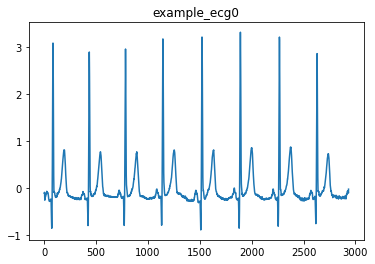

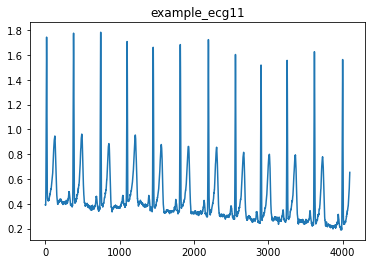

In [3]:
example_ecg0 = table_ecg[0][0]
example_ecg11 = table_ecg[11][0]
plt.plot(example_ecg0)
plt.title('example_ecg0')
plt.show()

plt.plot(example_ecg11)
plt.title('example_ecg11')
plt.show()

# First method : frequency of max amplitude in FFT

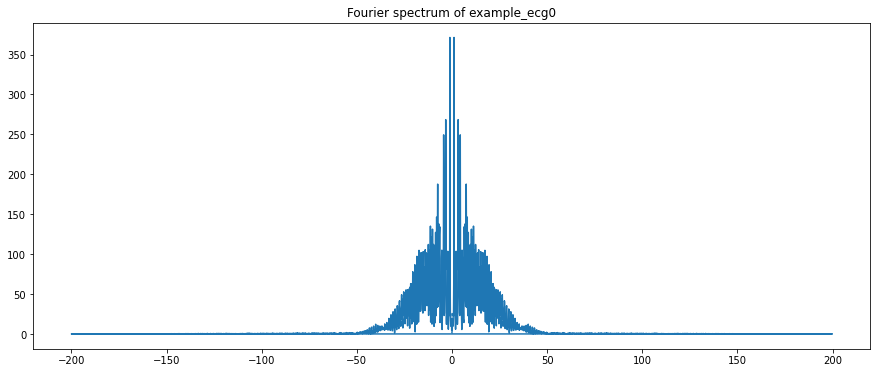

366.74999999999994


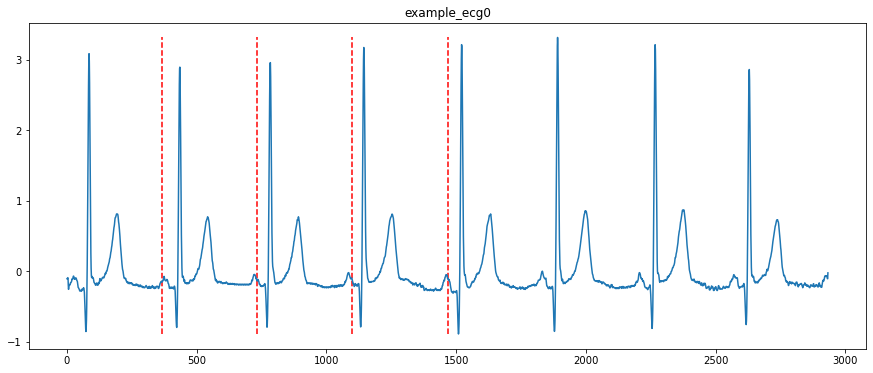

In [6]:
example_ecg0 = table_ecg[0][0]
fft_ecg0 = np.abs(np.fft.fft(example_ecg0))
frequencies = np.fft.fftfreq(np.size(example_ecg0),1/400)


plt.figure(figsize=(15,6))
plt.title('Fourier spectrum of example_ecg0')
plt.plot(frequencies,fft_ecg0)
plt.show()
principal_frequency_candidate = 400/np.abs(frequencies[np.argmax(fft_ecg0)])
print(principal_frequency_candidate)

plt.figure(figsize=(15,6))
plt.title('example_ecg0')
plt.vlines([principal_frequency_candidate,2*principal_frequency_candidate,3*principal_frequency_candidate,4*principal_frequency_candidate], [min(example_ecg0)],[max(example_ecg0)],colors='r', linestyles='dashed')
plt.plot(example_ecg0)
plt.show()

In [31]:
def freq_max_amplitude_in_fft(id,lead,trace=True):
    example_ecg = table_ecg[id][lead]
    fft_ecg = np.abs(np.fft.fft(example_ecg))
    frequencies = np.fft.fftfreq(np.size(example_ecg),1/400)
    
    resu = np.abs(frequencies[np.argmax(fft_ecg)])
    if resu==0:
        return 0
    
    else:
        principal_frequency_candidate = 400/np.abs(frequencies[np.argmax(fft_ecg)])

        #print(principal_frequency_candidate)

        if trace:
            plt.figure(figsize=(15,5))
            plt.title('Fourier spectrum of example_ecg'+str(id)+' for lead '+str(lead))
            plt.plot(frequencies,fft_ecg)
            plt.show()

            plt.figure(figsize=(15,5))
            plt.title('example_ecg'+str(id)+' for lead '+str(lead))
            #plt.vlines([principal_frequency_candidate,2*principal_frequency_candidate,3*principal_frequency_candidate,4*principal_frequency_candidate], [min(example_ecg0)],[max(example_ecg0)],colors='r', linestyles='dashed')
            plt.plot(example_ecg)
            plt.show()
        return principal_frequency_candidate

for id in range(np.shape(table_ecg)[0]):
    print([int(freq_max_amplitude_in_fft(id,lead,False)) for lead in range(np.shape(table_ecg)[1])])

[366, 366, 366, 366, 46, 366, 183, 366, 366, 366, 366, 366]
[261, 0, 0, 261, 0, 1567, 0, 0, 0, 0, 0, 0]
[133, 133, 266, 88, 133, 133, 266, 266, 266, 88, 133, 133]
[326, 326, 83, 326, 83, 326, 83, 326, 326, 326, 326, 326]
[88, 88, 66, 88, 88, 88, 88, 133, 88, 88, 88, 88]
[91, 54, 266, 91, 68, 54, 91, 34, 266, 266, 68, 68]
[293, 146, 146, 293, 146, 146, 586, 293, 293, 293, 293, 146]
[63, 586, 586, 104, 586, 63, 63, 326, 326, 63, 63, 63]
[195, 195, 419, 195, 419, 195, 195, 195, 65, 97, 195, 978]
[133, 133, 266, 1466, 133, 133, 266, 266, 266, 88, 88, 88]
[102, 102, 307, 307, 307, 307, 307, 102, 102, 102, 102, 307]
[0, 0, 0, 0, 0, 0, 0, 0, 4096, 0, 0, 0]
[65, 81, 81, 326, 81, 81, 163, 326, 326, 326, 81, 81]
[55, 91, 91, 266, 91, 55, 139, 139, 139, 55, 139, 91]
[86, 86, 127, 86, 52, 86, 65, 266, 37, 86, 86, 86]
[172, 122, 172, 172, 172, 172, 172, 172, 172, 172, 172, 172]
[419, 209, 419, 419, 209, 419, 139, 419, 419, 209, 209, 209]
[0, 0, 0, 4096, 0, 0, 0, 0, 0, 0, 0, 0]
[227, 0, 227, 227, 0,

[489, 88, 489, 489, 88, 88, 266, 266, 88, 88, 88, 88]
[49, 59, 293, 293, 293, 32, 293, 293, 293, 146, 59, 978]
[419, 104, 139, 419, 104, 104, 139, 209, 419, 419, 104, 326]
[112, 112, 112, 172, 112, 112, 112, 172, 112, 112, 112, 112]
[0, 0, 0, 0, 4096, 0, 0, 0, 0, 0, 0, 0]
[127, 366, 127, 127, 366, 366, 77, 29, 127, 366, 586, 366]
[326, 325, 326, 326, 326, 326, 326, 326, 326, 326, 104, 104]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[104, 154, 104, 104, 154, 104, 104, 326, 154, 154, 154, 154]
[366, 366, 366, 366, 366, 366, 172, 366, 586, 366, 117, 117]
[0, 0, 0, 0, 0, 0, 0, 0, 81, 0, 0, 0]
[366, 122, 366, 366, 183, 366, 183, 366, 366, 366, 366, 366]
[47, 47, 94, 94, 63, 47, 47, 47, 47, 47, 47, 47]
[366, 49, 366, 366, 366, 49, 244, 244, 27, 49, 49, 49]
[94, 53, 94, 94, 183, 94, 94, 366, 183, 366, 94, 94]
[91, 39, 91, 91, 39, 55, 91, 139, 91, 39, 39, 55]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 4096, 0, 0]
[366, 366, 183, 366, 366, 366, 366, 366, 27, 366, 586, 366]
[108,

[86, 172, 172, 172, 172, 86, 172, 86, 172, 172, 172, 172]
[0, 0, 0, 0, 0, 1365, 2048, 0, 0, 0, 2048, 0]
[163, 163, 326, 163, 326, 163, 733, 163, 326, 163, 163, 163]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[75, 75, 75, 293, 75, 75, 75, 75, 293, 293, 101, 101]
[293, 71, 293, 293, 71, 94, 71, 293, 293, 293, 94, 94]
[101, 58, 293, 101, 58, 58, 61, 154, 61, 61, 61, 61]
[104, 154, 154, 154, 154, 154, 366, 31, 326, 154, 154, 39]
[0, 0, 0, 2048, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 4096, 0, 0, 0, 0, 2048, 0, 0, 0]
[293, 59, 75, 293, 59, 59, 293, 75, 75, 101, 293, 101]
[139, 209, 139, 139, 139, 209, 419, 139, 419, 42, 139, 139]
[153, 2000, 2000, 153, 153, 153, 153, 153, 2000, 153, 2000, 2000]
[0, 0, 0, 0, 0, 0, 2048, 4096, 0, 0, 0, 0]
[51, 81, 68, 51, 68, 209, 68, 419, 419, 419, 58, 419]
[97, 97, 72, 97, 285, 97, 97, 97, 97, 72, 285, 97]
[333, 166, 333, 111, 333, 333, 333, 111, 111, 333, 333, 83]
[127, 127, 195, 195, 195, 127, 127, 127, 366, 127, 127, 127]
[293, 9

[104, 104, 209, 139, 104, 104, 104, 419, 139, 104, 104, 104]
[0, 0, 0, 0, 4096, 0, 4096, 4096, 4096, 0, 0, 0]
[104, 146, 293, 104, 146, 104, 104, 293, 293, 146, 104, 146]
[104, 154, 154, 104, 154, 62, 62, 154, 154, 154, 62, 62]
[0, 0, 0, 0, 0, 0, 0, 315, 0, 0, 0, 4096]
[733, 101, 195, 733, 101, 66, 101, 101, 586, 101, 101, 101]
[97, 97, 61, 154, 97, 97, 53, 244, 154, 154, 97, 97]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[146, 146, 146, 39, 146, 146, 146, 419, 419, 62, 146, 146]
[183, 366, 122, 122, 122, 183, 122, 52, 183, 183, 122, 122]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[117, 154, 183, 172, 183, 117, 209, 172, 172, 117, 117, 117]
[91, 91, 122, 366, 91, 91, 91, 183, 25, 91, 91, 91]
[0, 0, 4096, 4096, 4096, 0, 0, 4096, 4096, 0, 0, 0]
[163, 489, 366, 163, 366, 489, 366, 366, 366, 366, 366, 30]
[0, 0, 0, 0, 0, 4096, 0, 0, 0, 4096, 0, 0]
[293, 293, 75, 43, 293, 293, 293, 293, 293, 293, 154, 293]
[68, 266, 266, 586, 266, 266, 266, 266, 266, 266, 54, 54]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0

[326, 326, 326, 326, 326, 326, 51, 326, 326, 326, 326, 326]
[0, 2048, 0, 0, 0, 0, 0, 0, 0, 0, 4096, 0]
[104, 104, 52, 104, 52, 104, 154, 586, 1466, 104, 104, 104]
[107, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[444, 444, 444, 222, 444, 444, 444, 444, 444, 444, 444, 444]
[400, 400, 400, 97, 400, 400, 400, 400, 400, 400, 400, 200]
[146, 146, 39, 419, 146, 146, 146, 419, 419, 419, 419, 419]
[366, 91, 91, 183, 91, 366, 122, 0, 32, 366, 366, 366]
[117, 172, 117, 117, 43, 117, 117, 172, 172, 58, 172, 117]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[326, 326, 326, 326, 326, 326, 53, 326, 326, 326, 326, 326]
[104, 104, 23, 326, 23, 104, 586, 326, 326, 326, 104, 978]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[146, 59, 146, 146, 366, 146, 146, 293, 293, 101, 101, 59]
[95, 2000, 285, 31, 95, 95, 95, 95, 95, 95, 95, 2000]
[326, 66, 326, 326, 66, 55, 55, 326, 326, 326, 586, 489]
[95, 95, 21, 285, 285, 95, 95, 95, 95, 95, 95, 142]
[146, 146, 146, 146, 146, 146, 146, 733, 58, 58, 58, 58]
[112, 112, 112, 112, 112, 112, 